# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

In [49]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage import sobel
import cv2
from skimage import feature
from skimage import measure
import scipy.ndimage as nd
from scipy.fftpack import fft, ifft
from sklearn import svm

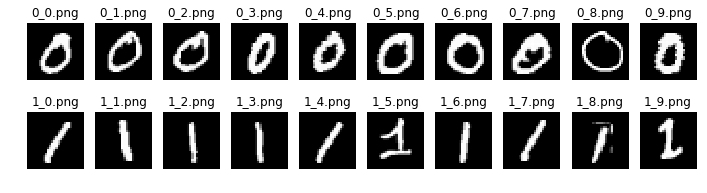

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Let's try first to detect the contours of each image as we did in the lab1

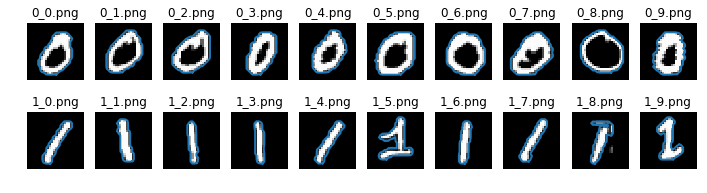

In [5]:
#for the zeros 
feature_descriptors_zero=np.zeros((10,2))
feature_descriptors_one=np.zeros((10,2))
i=0;
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    zero_contour=measure.find_contours(im,10) 
    # let's compute the complex signal based on the contours
    complex_signal_zero=zero_contour[0][:,0] + 1j*(zero_contour[0][:,1])
    # Now let's compute the fft signal 
    fourier_transform_zero=fft(complex_signal_zero)
    feature_descriptors_zero[i,0]=np.abs(fourier_transform_zero[1])
    feature_descriptors_zero[i,1]=np.abs(fourier_transform_zero[2])
    i=i+1
    ax.plot(zero_contour[0][:, 1], zero_contour[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
i=0
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    one_contour=measure.find_contours(im,10) 
    # let's compute the complex signal based on the contours
    complex_signal_one=one_contour[0][:,0] + 1j*(one_contour[0][:,1])
    # Now let's compute the fft signal 
    fourier_transform_one=fft(complex_signal_one)
    feature_descriptors_one[i,0]=np.abs(fourier_transform_one[1])
    feature_descriptors_one[i,1]=np.abs(fourier_transform_one[2])
    i=i+1
    ax.plot(one_contour[0][:, 1], one_contour[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [47]:
def plot_svm_seperator(X,Y,xmin,xmax,C): 
    clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C )
    clf.fit(x_train_scaled, Y.ravel())
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1.5, 2)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k-')

In [6]:
from sklearn import preprocessing
x_train=np.concatenate((feature_descriptors_zero,feature_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)

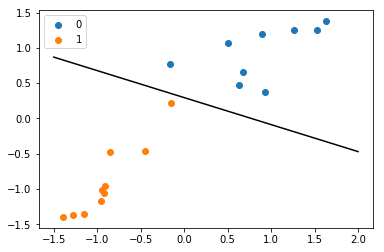

In [48]:
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 5 # SVM regularization parameter
clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C )
Y0=np.zeros((10,1))
Y1=np.ones((10,1)) 
Y=np.concatenate((Y0,Y1))
plot_svm_seperator(x_train_scaled,Y,-1,0.5,5)

### 1.3 Additional method(s)
#### 1- Region Based Descriptors
* ***Area and perimeter / Compacity and rectangularity*** 

In [57]:
#for the zeros 
area_perim_descriptors_zero=np.zeros((10,2))
area_perim_descriptors_one=np.zeros((10,2))
compacity_descriptors_zero=np.zeros((10,2))
compacity_descriptors_one=np.zeros((10,2))
i=0;
for  im, nm in zip( zeros_im, zeros_names):
    im[im>0]=1
    binary_im=im
    image_proprieties = measure.regionprops(binary_im)
    for prop in image_proprieties: 
        area_perim_descriptors_zero[i,0]=np.max(prop.area)
        area_perim_descriptors_zero[i,1]=np.max(prop.perimeter)
        compacity_descriptors_zero[i,0]=np.max(prop.perimeter**2/prop.area)
        compacity_descriptors_zero[i,1]=np.max(prop.area/prop.bbox_area )

        i+=1
i=0
for  im, nm in zip( ones_im, ones_names):
    im[im>0]=1
    binary_im=im
    image_proprieties = measure.regionprops(binary_im)
    for prop in image_proprieties: 
        area_perim_descriptors_one[i,0]=np.max(prop.area)
        area_perim_descriptors_one[i,1]=np.max(prop.perimeter) 
        compacity_descriptors_one[i,0]=np.max(prop.perimeter**2/prop.area)
        compacity_descriptors_one[i,1]=np.max(prop.area/prop.bbox_area)

        i+=1


In [68]:
prop.area

122

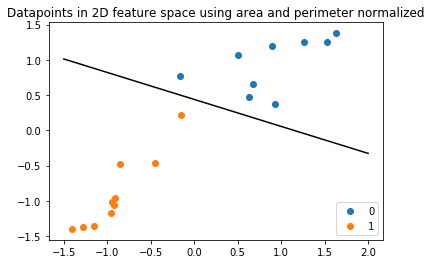

In [58]:
x_train=np.concatenate((area_perim_descriptors_zero,area_perim_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 10 # SVM regularization parameter
plt.title("Datapoints in 2D feature space using area and perimeter normalized")
plot_svm_seperator(x_train_scaled,Y,-1.5,2,C)

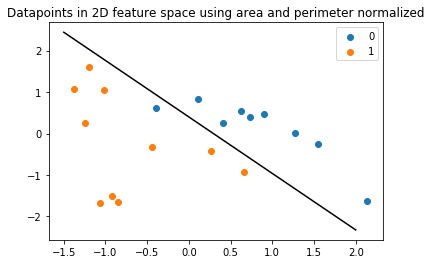

In [65]:
x_train=np.concatenate((compacity_descriptors_zero,compacity_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 50 # SVM regularization parameter
plt.title("Datapoints in 2D feature space using compacity and rectangularity normalized")
plot_svm_seperator(x_train_scaled,Y,-1.5,2,C)

In [87]:
i=0
import cv2 as cv
for  im, nm in zip( zeros_im, zeros_names):
    im[im>0]=1
    binary_im=im
    cont=cv.findContours(binary_im ,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
    image_proprieties = measure.regionprops(binary_im)
    